## Objective of spatially-coherent-random-perturbations 

We want to sample a certain kind of error, which pertain to errors/uncertainty in positions of
the structures in the fields in question. Some of them are commonly encountered in the context of 
DA for ocean observations. 

To do this, we want to randomly displace the structure in a given field, in a controllable manner.
The goal is to make this shifts random along with correlations in time. The time correlation aspect 
turns to be important as such errors needed to be added to the field over time.

The new field- so called the perturbed field is obtain by:
$$\hat u\left( x, t \right)= u \left(x + s_i (t, x), t\right)$$

To do this, 

* We choose correlation length scale. 
* we generate two random fields, one for random shift in $x$-direction and another for shift in $y$.
* The displacement field added to the old grid points to get new grid 
* We then perform normalization of the whole field to $[-1,1]$.
* We take care of the periodicity of the field.
* We then perform interpolation to get back the field on the new grid.

In [1]:
import os
import torch
import pandas as pd
import xarray as xr
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from grid import TwoGrid

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"
print('Active CUDA Device: GPU', torch.cuda.current_device())
device= torch.cuda.current_device()

Active CUDA Device: GPU 0


In [2]:
# We first load the true stream function/vorticity data
dataset=xr.load_dataset('../data/stream_function_dataset_forcing_no_t_lr_128_dt=0.0002_save_freq=1600.nc')

start_date='2023-10-01'

date_range = pd.date_range(start=start_date, periods=10, freq='D')
vorticity=dataset.vorticity.sel(time=date_range)
sf=dataset.stream_function.sel(time=date_range)

In [3]:
def generate_correlated_fields(N, L, T_corr, sigma, num_fields=10, device='cpu'):
    """
    Generate a series of 2D fields with both spatial and temporal correlations.

    Parameters:
        N (int): Grid size (assumed to be square, NxN).
        L (float): Spatial correlation length.
        T_corr (float): Temporal correlation length.
        sigma (float): Standard deviation of the field.
        num_fields (int): Number of fields to generate (default is 10).
        device (str): Device to run the computations on ('cpu' or 'cuda').

    Returns:
        torch.Tensor: Generated fields of shape (num_fields, N, N).
    """
    
    # Define the time points for the fields
    time_points = torch.linspace(0, num_fields - 1, num_fields, device=device)

    # Compute the temporal covariance matrix
    C_temporal = torch.exp(-abs(time_points[:, None] - time_points[None, :]) / T_corr)

    # Perform Cholesky decomposition to get the temporal correlation factors
    L_chol = torch.linalg.cholesky(C_temporal)

    # Generate independent Gaussian white noise for each time point
    white_noises = torch.randn((num_fields, N, N), device=device)

    # Combine white noise using the Cholesky factors to induce temporal correlation
    temporal_correlated_noises = torch.matmul(L_chol, white_noises.view(num_fields, -1)).view(num_fields, N, N)

    # Generate 2D grid of wavenumbers for spatial correlation
    kx = torch.fft.fftfreq(N, device=device) * N
    ky = torch.fft.fftfreq(N, device=device) * N
    k = torch.sqrt(kx[:, None]**2 + ky[None, :]**2)
    cutoff_mask = (k < 20).float()  # High-frequency cutoff
    # apply - if we apply the same approach to vorticity, and then obtain 
    # stream function, 
    # Spatial covariance (Power spectrum) for Gaussian covariance
    P_k = torch.exp(-0.5 * (k * L)**3)
    P_k[0, 0] = 0.0
    P_k = P_k / torch.sum(P_k)

    # Generate fields using Fourier transform
    fields = []
    for i in range(num_fields):
        noise_ft = torch.fft.fft2(temporal_correlated_noises[i])
        field_ft = noise_ft * sigma * torch.sqrt(P_k) * cutoff_mask
        field = torch.fft.ifft2(field_ft).real
        fields.append(field)
    return torch.stack(fields)

N = 128  # Grid size
L = 5.0  # Spatial correlation length
T_corr = 20.0  # Temporal correlation length
sigma = 25**2  # Standard deviation of the field

# Generate a Gaussian random field with a high-frequency cutoff
displacement_x = generate_correlated_fields(N, L, T_corr, sigma, device=device)
displacement_y = generate_correlated_fields(N, L, T_corr, sigma, device=device)

In [592]:
# fake_dx=torch.zeros_like(displacement_x)

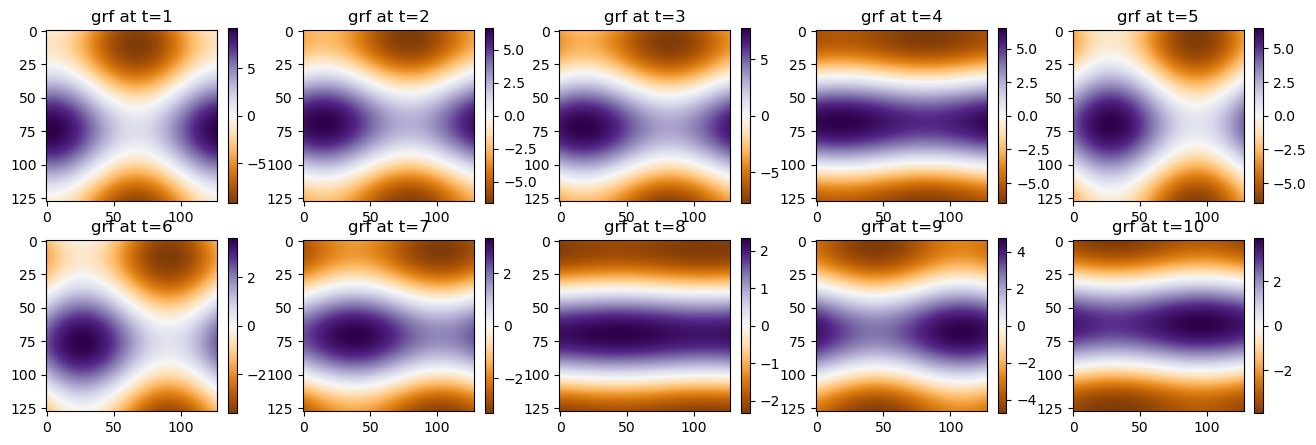

In [4]:
# We now generate a spatially correlated gaussian random field that we can
plt.figure(figsize=(16, 5))

for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(displacement_x[i].cpu().numpy(), cmap='PuOr')
    plt.colorbar()
    plt.title(f"grf at t={i+1}")

for i in range(5, 10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(displacement_x[i].cpu().numpy(), cmap='PuOr')
    plt.colorbar()
    plt.title(f"grf at t={i+1}")

plt.show()

In [5]:
# We now perturb the fields at the same way,
def warp_field(field, dx, dy):
    """
    Warp a 2D field based on displacement fields dx and dy.
    field (torch.Tensor): Input field of shape (batch_size, channels, height, width)
    dx (torch.Tensor): X-displacement field of shape (batch_size, height, width)
    dy (torch.Tensor): Y-displacement field of shape (batch_size, height, width)
    """
    batch_size, _, height, width = field.shape
    
    # Create base grid
    y, x = torch.meshgrid(torch.arange(height), torch.arange(width), indexing='ij')
    base_grid = torch.stack((x, y), dim=-1).float()
    
    # Add batch dimension and move to the same device as input field
    base_grid = base_grid.unsqueeze(0).repeat(batch_size,1,1,1).to(field.device)

    # Apply displacements
    sample_grid = base_grid + torch.stack((dx, dy), dim=-1)
    sample_grid[..., 0] = sample_grid[..., 0] % (width)
    sample_grid[..., 1] = sample_grid[..., 1] % (height)
    

    # Normalize grid to [-1, 1] range
    sample_grid[..., 0] = 2 * sample_grid[..., 0] / (width) - 1
    sample_grid[..., 1] = 2 * sample_grid[..., 1] / (height) - 1

    # Perform sampling
    warped_field = F.grid_sample(field, sample_grid, mode='bilinear', padding_mode='reflection', align_corners=False)
    return warped_field,torch.max(sample_grid), torch.min(sample_grid)


In [6]:
batch_size = 10
channels = 1
height, width = 128, 128

# Create a sample field (e.g., a gradient)
field = torch.from_numpy(sf.values).unsqueeze(1).float().to(device)
displacement_x = displacement_x 
displacement_y = displacement_y
mean_x=torch.tensor(25.0)
mean_y=torch.tensor(20.0)

# Perform warping
warped_field,max_grid,min_grid = warp_field(field, displacement_x+mean_x, displacement_y+mean_y)

print(f"Input field shape: {field.shape}")
print(f"Warped field shape: {warped_field.shape}")

Input field shape: torch.Size([10, 1, 128, 128])
Warped field shape: torch.Size([10, 1, 128, 128])


In [7]:

# Function to create a 2D Gaussian kernel
def gaussian_kernel(kernel_size=5, sigma=1.0, dtype=torch.float32, device='cuda'):
    # Create a 2D grid of coordinates (x, y)
    x = torch.arange(kernel_size, dtype=dtype, device=device) - (kernel_size - 1) / 2
    y = torch.arange(kernel_size, dtype=dtype, device=device) - (kernel_size - 1) / 2
    xx, yy = torch.meshgrid(x, y)

    # Compute the Gaussian function on the grid
    kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))

    # Normalize the kernel to ensure the sum of the weights is 1
    kernel = kernel / kernel.sum()
    return kernel

# Function to apply Gaussian smoothing to a batch of images
def apply_gaussian_smoothing(input_tensor, kernel_size=7, sigma=1.0):
    dtype = input_tensor.dtype
    device = input_tensor.device
    kernel = gaussian_kernel(kernel_size, sigma, dtype=dtype, device=device)
    
    # Reshape the kernel to be [1, 1, kernel_size, kernel_size] (for 2D convolution)
    kernel = kernel.view(1, 1, kernel_size, kernel_size)

    # Expand the kernel to apply it across all channels and the batch
    kernel = kernel.expand(1, 1, kernel_size, kernel_size)

    padding=kernel_size//2
    # Pad the input tensor with circular padding
    padded_input = F.pad(input_tensor, (padding, padding, padding, padding), mode='circular')

    # Apply the convolution (use groups=batch_size to apply the kernel individually per batch element)
    smoothed_tensor = F.conv2d(padded_input, kernel, groups=1)

    # Remove the extra channel dimension
    return smoothed_tensor 


In [10]:
#warped_field,max_grid,min_grid = warp_field(field, smoothed_dx, smoothed_dy)

# option 2: applying perturbation directly to vorticity and invert to get stream function.
# option 3: draw samples in space and apply RBF, covariance depening on the distance function..
# draw positions, draw values, and use RBF interpolation, 

In [11]:
# Smmothing
smoothed_tensor=apply_gaussian_smoothing(warped_field,kernel_size=15,sigma=1.5)


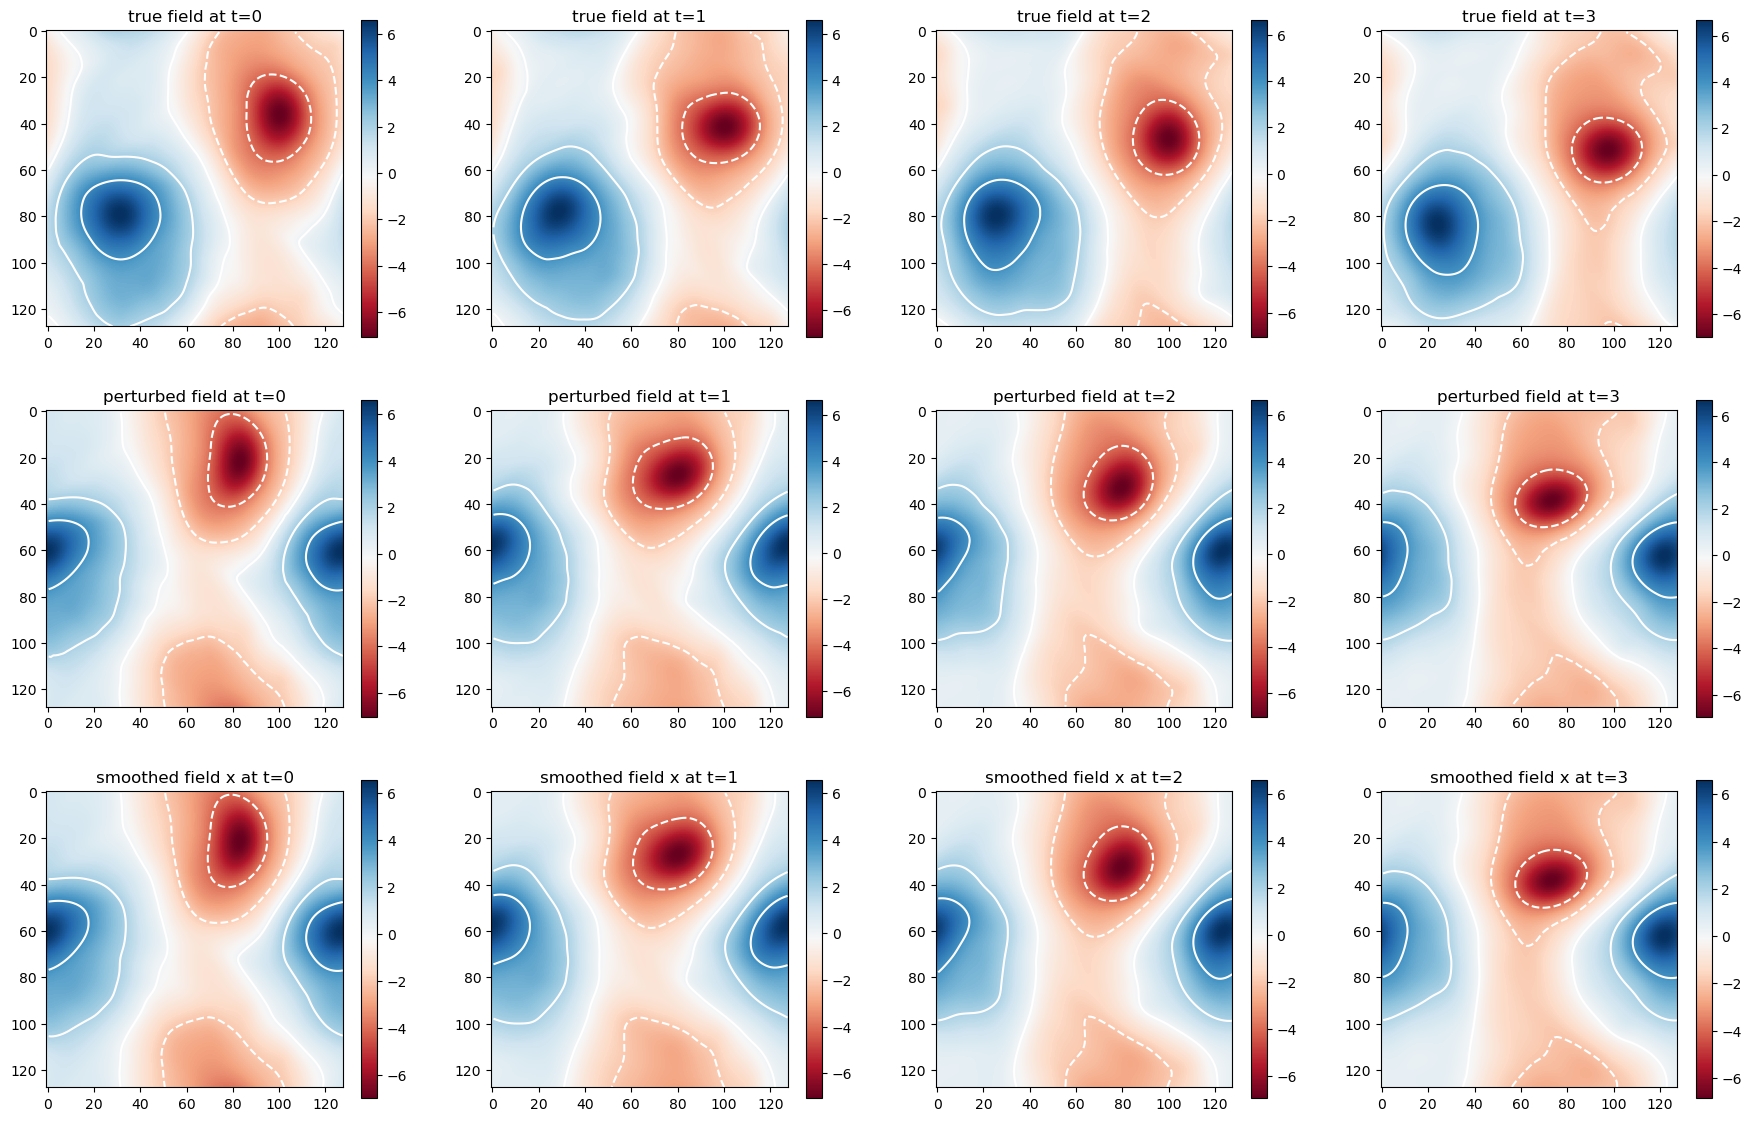

In [13]:
# Plot the column wise field 
specific_levels=[-4,-2,0,2,4]
plt.figure(figsize=(22,14))
for i in range(4):
    plt.subplot(3,4,i+1)
    plt.imshow(field[i,0].cpu().numpy(), cmap='RdBu')
    plt.colorbar()
    plt.contour(field[i,0].cpu().numpy(), levels=specific_levels, colors='white', linewidths=1.5, origin='lower', extent=[0, 128, 0, 128])
    plt.title(f'true field at t={i}')

    plt.subplot(3,4,5+i)
    plt.imshow(warped_field[i,0].cpu().numpy(), cmap='RdBu')
    plt.colorbar()
    plt.title(f'perturbed field at t={i}')
    plt.contour(warped_field[i,0].cpu().numpy(), levels=specific_levels, colors='white', linewidths=1.5, origin='lower', extent=[0, 128, 0, 128])

    plt.subplot(3,4,9+i)
    plt.imshow(smoothed_tensor[i,0].cpu().numpy(), cmap='RdBu')
    plt.colorbar()
    plt.title(f'smoothed field x at t={i}')
    plt.contour(smoothed_tensor[i,0].cpu().numpy(), levels=specific_levels, colors='white', linewidths=1.5, origin='lower', extent=[0, 128, 0, 128])


In [14]:
# Computing vorticity from the perturbed fields
my_grid=TwoGrid(device=device,Nx=128, Ny=128, Lx=2*torch.pi, Ly=2*torch.pi, dealias=1/3)

In [15]:
ptb_sf_fr=torch.fft.rfftn(warped_field, norm='forward', dim = [-2,-1])
sth_sf_fr=torch.fft.rfftn(smoothed_tensor, norm='forward', dim = [-2,-1])
true_sf_fr=torch.fft.rfftn(field, norm='forward', dim = [-2,-1])

# vorticity
ptb_vorticity= torch.fft.irfftn(my_grid.laplacian(ptb_sf_fr), norm='forward', dim = [-2,-1])
sth_vorticity= torch.fft.irfftn(my_grid.laplacian(sth_sf_fr), norm='forward', dim = [-2,-1])

true_field_grad=torch.fft.irfftn(my_grid.grad(true_sf_fr),norm='forward',dim=[-2,-1])
ptb_field_grad=torch.fft.irfftn(my_grid.grad(ptb_sf_fr),norm='forward',dim=[-2,-1])
smooth_field_grad=torch.fft.irfftn(my_grid.grad(sth_sf_fr),norm='forward',dim=[-2,-1])

Text(0.5, 1.0, 'true grad_x at t=3')

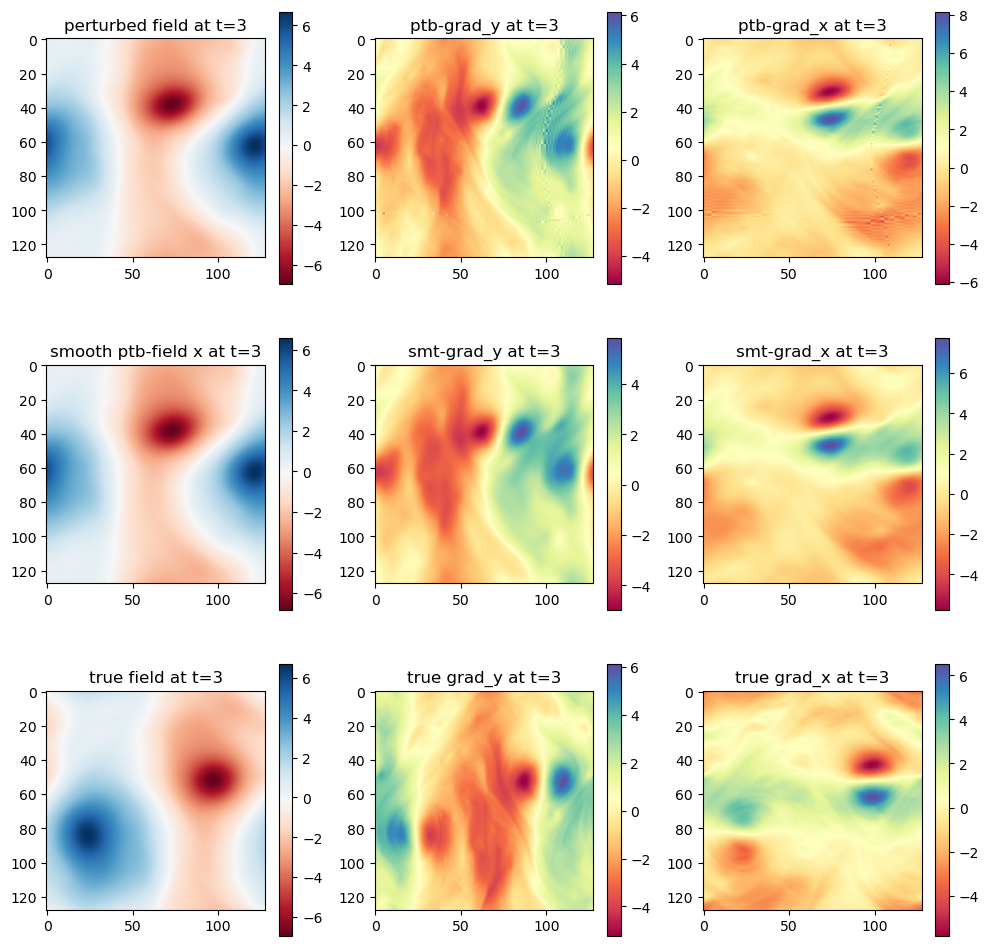

In [16]:
# Plot the column true and perturbed fields, and their gradients 
j=3

plt.figure(figsize=(12,12))
plt.subplot(3,3,1)
plt.imshow(warped_field[j,0].cpu().numpy(), cmap='RdBu')
plt.colorbar()
plt.title(f'perturbed field at t={j}')

plt.subplot(3,3,2)
plt.imshow(ptb_field_grad[0,j,0].cpu().numpy(), cmap='Spectral')
plt.colorbar()
plt.title(f'ptb-grad_y at t={j}')

plt.subplot(3,3,3)
plt.imshow(ptb_field_grad[1,j,0].cpu().numpy(), cmap='Spectral')
plt.colorbar()
plt.title(f'ptb-grad_x at t={j}')

plt.subplot(3,3,4)
plt.imshow(smoothed_tensor[j,0].cpu().numpy(), cmap='RdBu')
plt.colorbar()
plt.title(f'smooth ptb-field x at t={j}')

plt.subplot(3,3,5)
plt.imshow(smooth_field_grad[0,j,0].cpu().numpy(), cmap='Spectral')
plt.colorbar()
plt.title(f'smt-grad_y at t={j}')

plt.subplot(3,3,6)
plt.imshow(smooth_field_grad[1,j,0].cpu().numpy(), cmap='Spectral')
plt.colorbar()
plt.title(f'smt-grad_x at t={j}')

plt.subplot(3,3,7)
plt.imshow(field[j,0].cpu().numpy(), cmap='RdBu')
plt.colorbar()
plt.title(f'true field at t={j}')

plt.subplot(3,3,8)
plt.imshow(true_field_grad[0,j,0].cpu().numpy(), cmap='Spectral')
plt.colorbar()
plt.title(f'true grad_y at t={j}')

plt.subplot(3,3,9)
plt.imshow(true_field_grad[1,j,0].cpu().numpy(), cmap='Spectral')
plt.colorbar()
plt.title(f'true grad_x at t={j}')

Text(0.5, 1.0, 'perturbed vorticity at t=2')

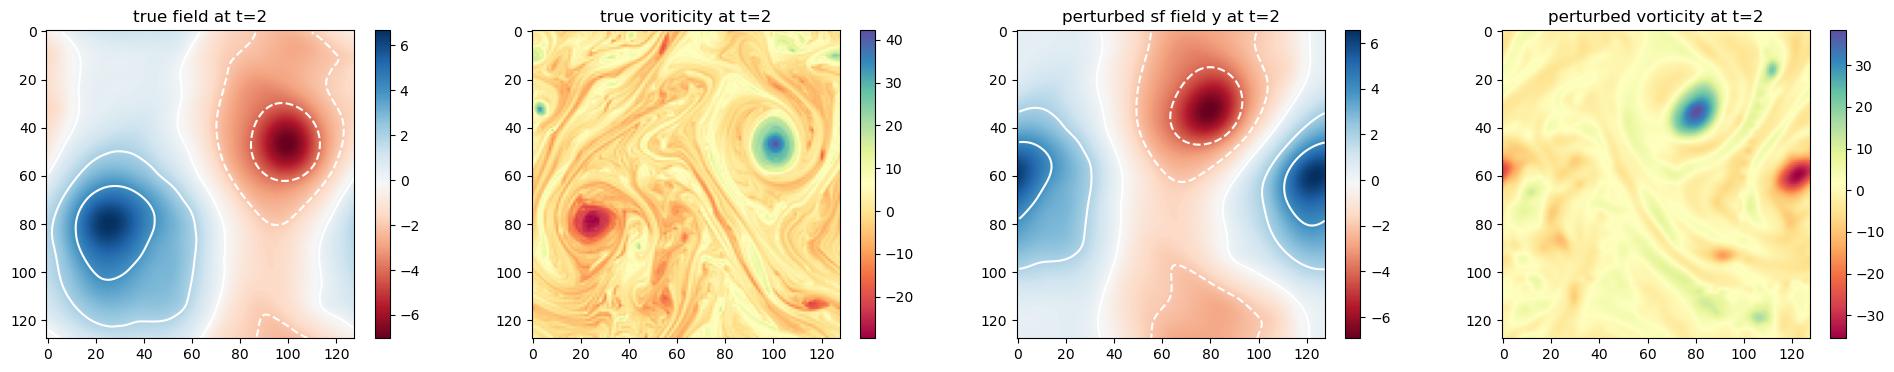

In [17]:
# Plot the true sf, true vorticity, perturbed sf, perturbed vorticity
# Plot the column wise field 
j=2

plt.figure(figsize=(24,4))
plt.subplot(1,4,1)
plt.imshow(field[j,0].cpu().numpy(), cmap='RdBu')
plt.colorbar()
plt.contour(field[j,0].cpu().numpy(), levels=specific_levels, colors='white', linewidths=1.5, origin='lower', extent=[0, 128, 0, 128])
plt.title(f'true field at t={j}')

plt.subplot(1,4,2)
plt.imshow(vorticity[j].values, cmap='Spectral')
plt.colorbar()
plt.title(f'true voriticity at t={j}')

plt.subplot(1,4,3)
plt.imshow(smoothed_tensor[j,0].cpu().numpy(), cmap='RdBu')
plt.colorbar()
plt.contour(smoothed_tensor[j,0].cpu().numpy(), levels=specific_levels, colors='white', linewidths=1.5, origin='lower', extent=[0, 128, 0, 128])

plt.title(f'perturbed sf field y at t={j}')

plt.subplot(1,4,4)
plt.imshow(sth_vorticity[j,0].cpu().numpy(), cmap='Spectral')
plt.colorbar()
plt.title(f'perturbed vorticity at t={j}')

In [18]:
# PSD spectrum ....
# Constrain the spectrum to the true state...
# laplacian in physical space...
# Apply spatial avergaing after perturbation to stream function.


In [19]:

def compute_psd(image):
    """
    Compute the 2D Power Spectral Density of an image.
    
    Args:
        image (torch.Tensor): Input image tensor of shape (H, W) or (C, H, W)
        
    Returns:
        torch.Tensor: Power Spectral Density
    """
    # If image has channels, convert to grayscale by averaging
    if len(image.shape) == 3:
        image = image.mean(dim=0)
    
    # Compute 2D FFT
    fft = torch.fft.fft2(image)
    
    # Shift zero frequency to center
    fft_shifted = torch.fft.fftshift(fft)
    
    # Compute power spectrum
    psd = torch.abs(fft_shifted) ** 2
    
    # Normalize
    psd = torch.log1p(psd)  # Use log scale for better visualization
    
    return psd

def plot_psd_comparison(image1, image2, titles=None, figsize=(6, 4)):
    """
    Plot two images and their corresponding PSDs side by side.
    
    Args:
        image1 (torch.Tensor): First input image
        image2 (torch.Tensor): Second input image
        titles (tuple): Optional tuple of strings (title1, title2)
        figsize (tuple): Figure size
    """
    if titles is None:
        titles = ('Image 1', 'Image 2')
    
    # Compute PSDs
    psd1 = compute_psd(image1)
    psd2 = compute_psd(image2)
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Plot original images
    im3=axes[0, 0].imshow(image1.cpu().squeeze(), cmap='RdBu')
    axes[0, 0].set_title(f'{titles[0]} - Original')
    axes[0, 0].axis('off')
    plt.colorbar(im3, ax=axes[0, 0])

    im0=axes[0, 1].imshow(image2.cpu().squeeze(), cmap='RdBu')
    axes[0, 1].set_title(f'{titles[1]} - Original')
    axes[0, 1].axis('off')
    plt.colorbar(im0, ax=axes[0, 1])

    # Plot PSDs
    im1 = axes[1, 0].imshow(psd1.cpu(), cmap='viridis')
    axes[1, 0].set_title(f'{titles[0]} - PSD')
    axes[1, 0].axis('off')
    plt.colorbar(im1, ax=axes[1, 0])
    
    im2 = axes[1, 1].imshow(psd2.cpu(), cmap='viridis')
    axes[1, 1].set_title(f'{titles[1]} - PSD')
    axes[1, 1].axis('off')
    plt.colorbar(im2, ax=axes[1, 1])
    
    plt.tight_layout()
    return fig

def compare_psd_metrics(image1, image2):
    """
    Compute comparison metrics between two PSDs.
    
    Args:
        image1 (torch.Tensor): First input image
        image2 (torch.Tensor): Second input image
        
    Returns:
        dict: Dictionary containing comparison metrics
    """
    psd1 = compute_psd(image1)
    psd2 = compute_psd(image2)
    
    # Compute various comparison metrics
    mse = torch.mean((psd1 - psd2) ** 2)
    mae = torch.mean(torch.abs(psd1 - psd2))
    
    # Normalize PSDs for correlation
    psd1_norm = (psd1 - psd1.mean()) / psd1.std()
    psd2_norm = (psd2 - psd2.mean()) / psd2.std()
    correlation = torch.mean(psd1_norm * psd2_norm)
    
    return {
        'mse': mse.item(),
        'mae': mae.item(),
        'correlation': correlation.item()
    }

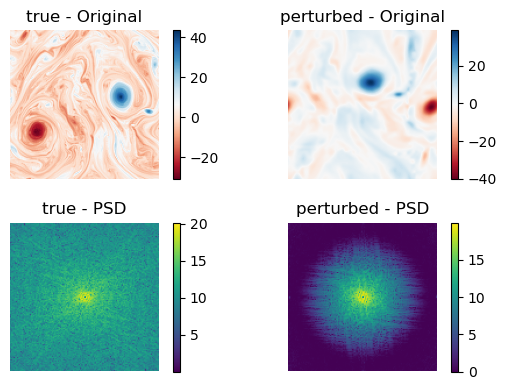

In [20]:

# Plot comparison
j=4
fig = plot_psd_comparison(torch.from_numpy(vorticity[j].values), sth_vorticity[j,0], titles=('true', 'perturbed'))


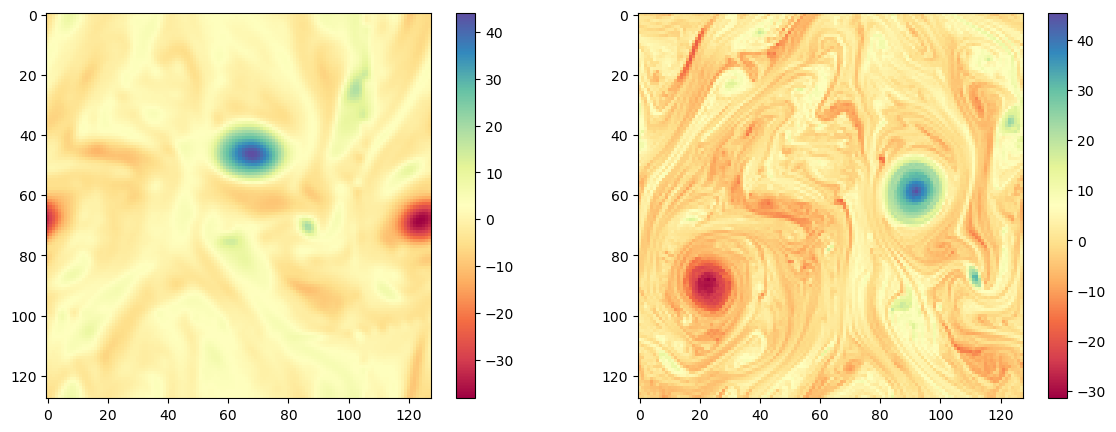

In [21]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.imshow(sth_vorticity[5,0].cpu(),cmap='Spectral')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(vorticity[5].values,cmap='Spectral')
plt.colorbar()

### Applying perturbations in vorticity space then inverting to stream-function

Earlier demostrations do show some kind of small artifacts, which can be removed by smoothing. 
The smoothed field makes more sense for low dimensional problems as the fine scale simulations
require high resolution simulations.

We now introduce the perturbations in the vorticity space and invert to the stream function space
to obtain the perturbed field. This yields better results at the moment. However, it should be possible to do the same for the previous method once it is clear how to eliminate the artifacts.

In [22]:

# Create a sample field (e.g., a gradient)
field = torch.from_numpy(vorticity.values).unsqueeze(1).float().to(device)
displacement_x = displacement_x 
displacement_y = displacement_y

mean_x=torch.tensor(10.0)
mean_y=torch.tensor(10.0)
# Perform warping
warped_field,max_grid,min_grid = warp_field(field, displacement_x+mean_x, displacement_y+mean_y)

print(f"Input field shape: {field.shape}")
print(f"Warped field shape: {warped_field.shape}")

Input field shape: torch.Size([10, 1, 128, 128])
Warped field shape: torch.Size([10, 1, 128, 128])


In [23]:
smoothed_tensor=apply_gaussian_smoothing(warped_field,kernel_size=11,sigma=0.5)

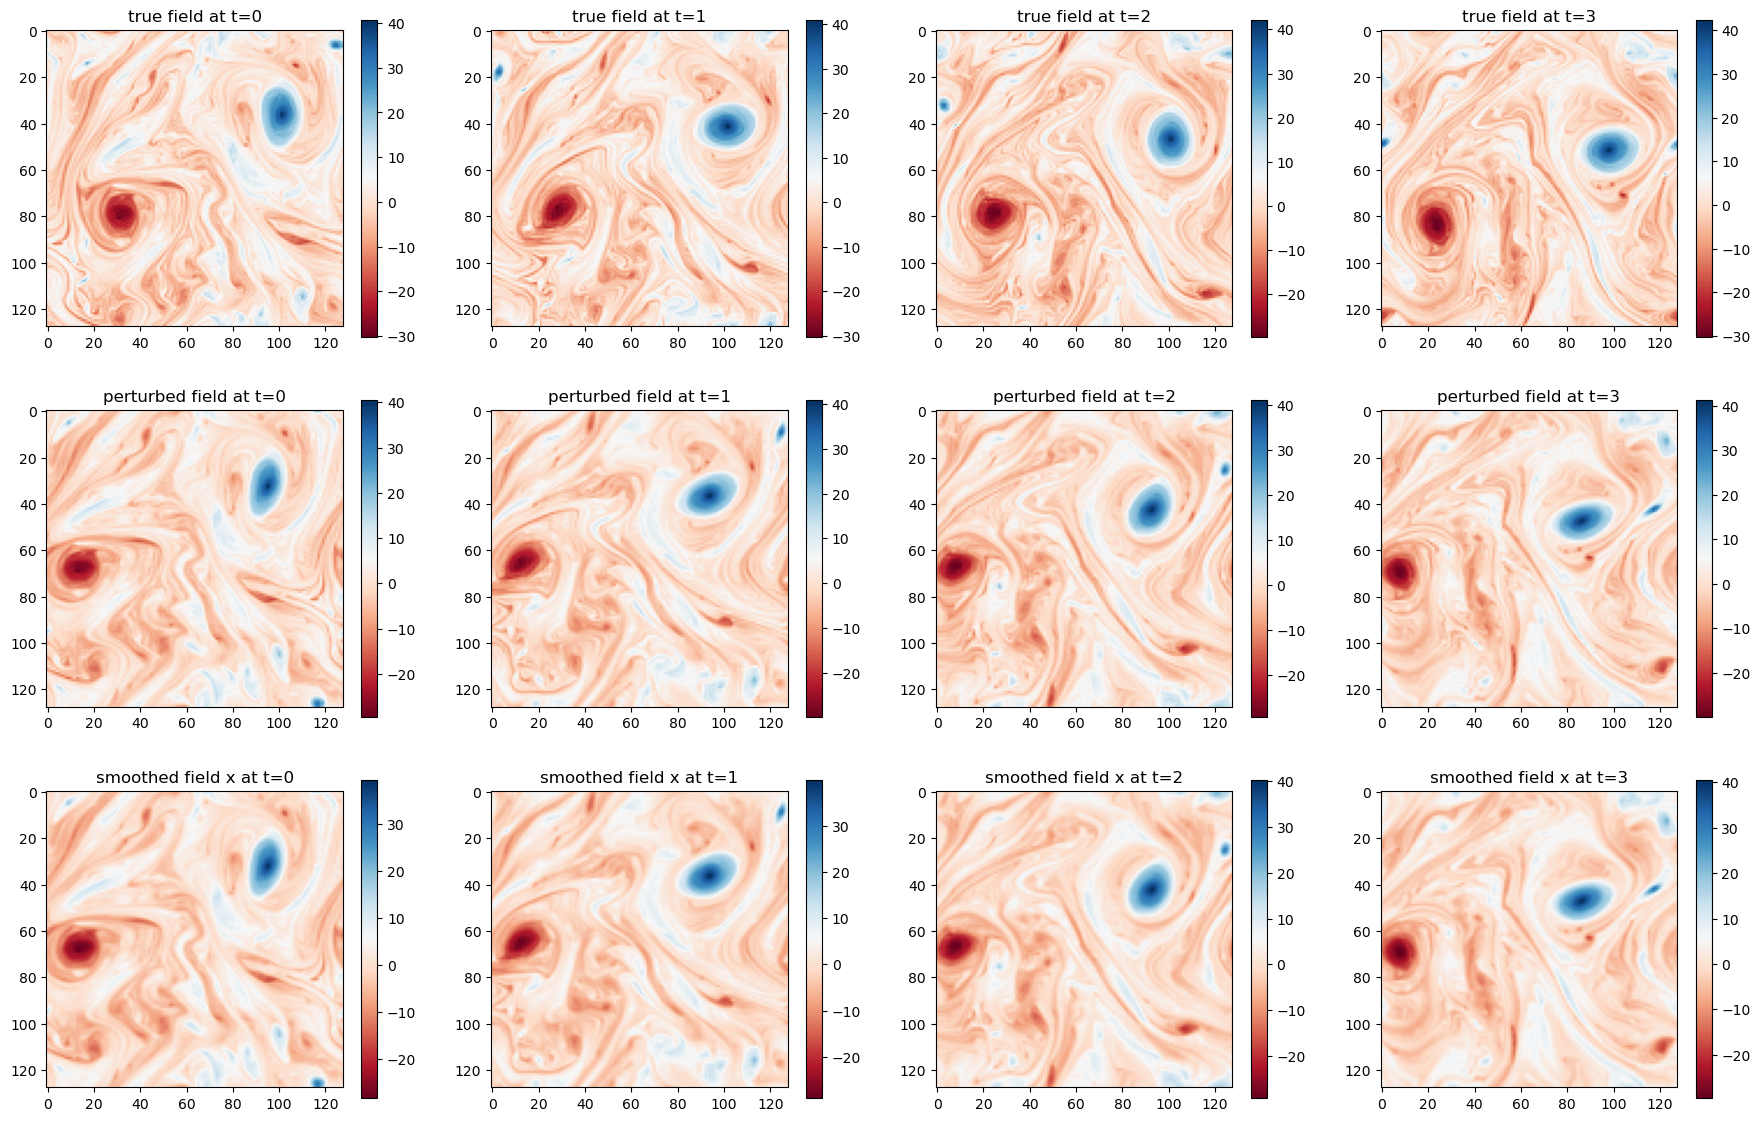

In [24]:
# Plot the column wise field 
plt.figure(figsize=(22,14))
for i in range(4):
    plt.subplot(3,4,i+1)
    plt.imshow(field[i,0].cpu().numpy(), cmap='RdBu')
    plt.colorbar()
    plt.title(f'true field at t={i}')

    plt.subplot(3,4,5+i)
    plt.imshow(warped_field[i,0].cpu().numpy(), cmap='RdBu')
    plt.colorbar()
    plt.title(f'perturbed field at t={i}')

    plt.subplot(3,4,9+i)
    plt.imshow(smoothed_tensor[i,0].cpu().numpy(), cmap='RdBu')
    plt.colorbar()
    plt.title(f'smoothed field x at t={i}')


In [25]:
# apply the invserse transformation to get sf from the perturbed vorticity:
true_vor_fr=torch.fft.rfftn(field, norm='forward', dim = [-2,-1])
ptb_vor_fr=torch.fft.rfftn(warped_field, norm='forward', dim = [-2,-1])


# Stream function from voerticity
ptb_sf_fr=- ptb_vor_fr * my_grid.irsq.unsqueeze(0)
ptb_sf= torch.fft.irfftn(ptb_sf_fr, norm='forward', dim=[-2, -1])


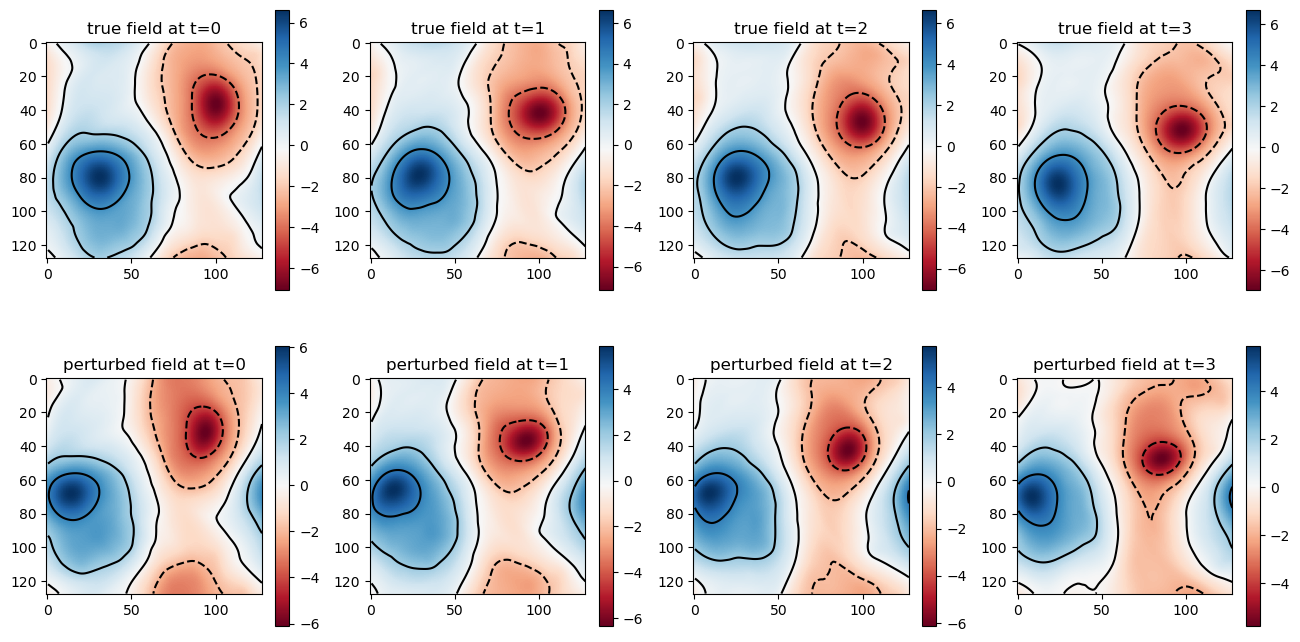

In [32]:
# Plot the column wise field 
plt.figure(figsize=(16,8))
for i in range(4):
    plt.subplot(2,4,i+1)
    plt.imshow(sf[i].values, cmap='RdBu')
    plt.colorbar()
    plt.contour(sf[i].values, levels=specific_levels, colors='black', linewidths=1.5, origin='lower', extent=[0, 128, 0, 128])
    plt.title(f'true field at t={i}')

    plt.subplot(2,4,5+i)
    plt.imshow(ptb_sf[i,0].cpu(), cmap='RdBu')
    plt.colorbar()
    #plt.contour(sf[i].values, levels=specific_levels, colors='white', linewidths=1.5, origin='lower', extent=[0, 128, 0, 128])
    plt.contour(ptb_sf[i,0].cpu(), levels=specific_levels, colors='black', linewidths=1.5, origin='lower', extent=[0, 128, 0, 128])
    plt.title(f'perturbed field at t={i}')
